original post
https://medium.com/analytics-vidhya/implementing-gradient-descent-for-multi-linear-regression-from-scratch-3e31c114ae12

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import random
from decimal import Decimal
import timeit

DS_NAME = 'Boston' # 'Boston' / 'California' / 'Ames'(Not Work yet, need further data-cleaning)

LR      = 0.005    # learning rate
EPOCH   = 500      # epochs for train
LOG     = 100      # log print Modular, i.e. pint log for each LOG iteration
N_BATCH = 5        # number of Batch, only valid for mini-batch SGD
Test_split = 0.2   # dataset train-test split threshold
SEED    = 2022     # seed for split


## Dataset prepare

In [2]:
if   DS_NAME == 'Boston': # data-set prepare Boston housing dataset
    import pandas as pd
    import numpy as np

    data_url  = "http://lib.stat.cmu.edu/datasets/boston"
    housing   = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    X_orginal = np.hstack([housing.values[::2, :], housing.values[1::2, :2]])
    y_full    = housing.values[1::2, 2]
    
    N_BATCH   = 5
    

elif DS_NAME == 'California':    # data-set prepare California housing dataset
    from sklearn.datasets import fetch_california_housing
    housing   = fetch_california_housing()
    X_orginal = housing.data
    y_full    = housing.target
    
    N_BATCH   = 10
    
    
elif DS_NAME == 'Ames':    # data-set prepare Ames housing dataset, not working yet.
    from sklearn.datasets import fetch_openml
    housing   = fetch_openml(name="house_prices", as_frame=True)
    X_orginal = housing.data
    y_full    = housing.target

    N_BATCH   = 10
else:
    print (f"ERRO: not recognized DS NAME {DS_NAME}")

print("dataset summary:")
print(f"{housing}")

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_26050/3085580519.py:6: SyntaxWarning: invalid escape sequence '\s'
  housing   = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


dataset summary:
             0      1      2    3      4      5     6       7    8      9   \
0       0.00632  18.00   2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1     396.90000   4.98  24.00  NaN    NaN    NaN   NaN     NaN  NaN    NaN   
2       0.02731   0.00   7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
3     396.90000   9.14  21.60  NaN    NaN    NaN   NaN     NaN  NaN    NaN   
4       0.02729   0.00   7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
...         ...    ...    ...  ...    ...    ...   ...     ...  ...    ...   
1007  396.90000   5.64  23.90  NaN    NaN    NaN   NaN     NaN  NaN    NaN   
1008    0.10959   0.00  11.93  0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
1009  393.45000   6.48  22.00  NaN    NaN    NaN   NaN     NaN  NaN    NaN   
1010    0.04741   0.00  11.93  0.0  0.573  6.030  80.8  2.5050  1.0  273.0   
1011  396.90000   7.88  11.90  NaN    NaN    NaN   NaN     NaN  NaN    NaN   

        10  
0     15.3  
1      NaN  
2     1

In [3]:
# data rescaling
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
X_full  = sc.fit_transform(X_orginal)
TOTAL_SAMPLE = len(X_full)

# data-set partition
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X_full, y_full, test_size=Test_split, random_state=SEED)

# M = len(X_train[0]) # features number
# N = len(X_train)    # samples number
BATCH_SZ = int (TOTAL_SAMPLE/N_BATCH)  # batch size, only for mb-SGD

print(f"X shape = {X_train.shape}, y shape = {y_train.shape}")
print(f"Train dataset sample number={len(X_train)}, Test dataset sample number={len(X_test)}")

X shape = (404, 13), y shape = (404,)
Train dataset sample number=404, Test dataset sample number=102


## Equation of linear regression


$$
y_{pred}=w_{1}x_{1}+w_{2}x_{2}+...+w_{m}x_{m}=W*X+b  -- eq(1)
$$
$$
l_{j}=(y_{j}-y_{j_{-}pred})^{2}  -- eq(2)
$$

$$
l_{mse}=\frac{1}{n}\sum_{j=1}^{n}l_{j}=\frac{1}{n}\sum_{j=1}^{n}(y_{j}-y_{j_{-}pred})^{2}=\frac{1} {n}\sum_{j=1}^{n}[y_{j}-(W*X_{j}+b)]^{2} -- eq(3)
$$

$$
\frac{dl_{mse}}{dW}=\frac{2}{n}\sum_{j=1}^{n}[-X_{j}(y_{j}-(W*X_{j}+b))]    -- eq(4)
$$

$$
\frac{dl_{mse}}{db}=\frac{2}{n}\sum_{j=1}^{n}[-(y_{j}-(W*X_{j}+b))]    -- eq(5)
$$

$$
W_{update}=W_{old}-lr*\sum_{j=1}^{n}\frac{dl_{j}}{dW}   -- eq (6)
$$
$$
b_{update}=b_{old}-lr*\sum_{j=1}^{n}\frac{dl_{j}}{db}   -- eq(7)
$$



In [4]:
# Equation
def pred_onesample (W, X, b):   # eq(1)单样本输出
    return W@X + b

def predicted_y(W, X, b):       # eq(1)的多样本计算
    y_list=[]
    for j in range(len(X)):
        y_list.append(pred_onesample(W, X[j], b))  
    return np.array(y_list)

def mse_onesample (y, ypred):   # eq(2)单样本的mse计算
    return (y - ypred)**2

def loss_mse(y, ypred):         # eq(3)多样本mse计算
    loss_sum = 0.0
    n = len(y)
    for j in range(n):
        loss_sum += mse_onesample (y[j], ypred[j])
    return loss_sum/n 

def loss_wrt_W_onesample(X, y, ypred):   # dl/dw 单样本计算
    return -1*X*(y - ypred)

def loss_wrt_W(X, y, ypred):             # eq(4) dl/dw 多样本计算
    s = 0
    n = len(y)
    for i in range(n):
        s += loss_wrt_W_onesample(X[i], y[i], ypred[i])
    return (2/n)*s

def loss_wrt_b_onesample(y, ypred):      # dl/db 单样本计算
    return -1*(y - ypred)

def loss_wrt_b(y, y_pred):               # eq(5) dl/db 多样本计算
    n=len(y)
    s=0
    for i in range(len(y)):
         s += loss_wrt_b_onesample(y[i], y_pred[i])
    return (2/n) * s


In [5]:
def predict(Xin, W, b):
    """Based on input Data Xin, using Model (W,b) for prediction"""
    y_lst=[]
    for i in range(len(Xin)):
        y_lst.append( W@Xin[i] + b )
    return np.array(y_lst)

def mse_loss(predict_lst, target_lst):
    return loss_mse(predict_lst, target_lst)

def test(Xin, yin, W, b):
    ypred_lst = predict (Xin, W, b)
    test_mse  = mse_loss(ypred_lst, yin)
    d = Decimal(str(test_mse)).quantize(Decimal("0.001"), rounding = "ROUND_HALF_UP")
    d_str = f"test loss: {d}"
    return d_str
    

In [6]:
## timing decorator
def timing(func):
    """decoration for timing calculation"""
    def get_timing(*args, **kwargs):
        _begin = timeit.default_timer()
        result = func(*args, **kwargs)
        duration = timeit.default_timer() - _begin
        d = Decimal(str(duration)).quantize(Decimal("0.001"), rounding = "ROUND_HALF_UP")
        d_str = f"time: {d} sec"
        print(f"{func.__name__} takes {d_str} seconds\n")
        return result, d_str
    return get_timing

In [7]:
# [GD] within each epoch, using all samples to compute and update the mean of result
@timing
def gradient_descent(X_l, y_l, epochs):

    W = np.random.randn(X_l.shape[1])
    b = np.random.rand()
    mse_loss_list=[]
    lr = LR

    for e in range(1, epochs+1):
       
        y_lpred = predicted_y(W, X_l, b)
        
        W = W - lr * loss_wrt_W(X_l, y_l, y_lpred) # W regression
        
        b = b - lr * loss_wrt_b(y_l, y_lpred)      # b regression
        
        loss = loss_mse(y_l, y_lpred)
        
        if e % LOG == 0: 
            print(f"[   GD] | epoch: [{e} / {epochs}] | loss = {loss:.4f}")
        
        mse_loss_list.append(loss)
            
#     plot_xy(np.arange(1, epochs), mse_loss_list[1:], "[GD]epoch", "loss")
   
    return W, b, np.arange(1, epochs), mse_loss_list[1:]

In [8]:
# [SGD] experiment, using multiple sample inside SGD epoch
SAMPLE_RATE = 0.5   # SAMPLE_RATE = 0, degradiate to the classic SGD, Max = 1.0
@timing
def stocastic_gradient_descent_sampling(X, y, epochs):
    W = np.random.randn(X.shape[1]) 
    b = np.random.rand()
    mse_loss_list=[]
    lr = LR
    
    n  = len(X)  # number of sample
    
    M  = int (n*SAMPLE_RATE) # iteration times inside a SGD loop, at least 1
    M  = 1 if M < 1 else M   # M = 1 classic SGD
    print(f"[  SGD] | Computing {M} samples per epoch:")
    
    n_iter = []
    c_iter = 1
    
    for e in range(1, epochs+1):
        loss_j = 0.0
        y_l = []
        y_pred_l = []
        
        for j in range(M):
            rand_ind = random.randint(0, n-1)        
            X_onesample = X[rand_ind]
            y_onesample = y[rand_ind]
            
            # update of weight and bias for only one sample
            y_pred = pred_onesample(W, X_onesample, b)
            
            # weight and b are still need to be scale down by /n, to preventing overflow happen
            W = W - lr * loss_wrt_W_onesample(X_onesample, y_onesample, y_pred)*2/n
            b = b - lr * loss_wrt_b_onesample(y_onesample, y_pred)*2/n
            
            y_l.append(y_onesample)
            y_pred_l.append(y_pred)
            n_iter.append(c_iter)
            c_iter += 1
            
        mse_loss_list.append(loss_mse(y_l, y_pred_l))
        
        if e % LOG == 0: 
            print(f"[  SGD] | epoch: [{e} / {epochs}], compute using sample[{rand_ind}] randomly")
        
#     plot_xy(np.arange(1, epochs), mse_loss_list[1:], "[SGD]epoch", "loss")

    return W, b, np.arange(1, epochs), mse_loss_list[1:]
#     return W, b, n_iter, mse_loss_list[1:]

In [9]:
# [mbSGD] within each epoch, divide whole dataset to some sub-set(batch), using all samples in the batch(batch_size) to compute and update the mean of result
@timing
def mb_stocastic_gradient_descent(X, y, epochs):
    W = np.random.randn(X.shape[1])
    b = np.random.rand()
    mse_loss_list=[]
    lr = LR
    
    n  = len(X)

    n_iter = []
    c_iter = 1
    batch_size=101
    
    for e in range(1, epochs+1):
        iter_per_epoch = int(n/batch_size)
        for j in range(iter_per_epoch):
            # generate a batch index list by random selection
            rand_ind_list = np.random.choice(X.shape[0], batch_size, replace=False)
            X_samples = X[rand_ind_list]
            y_samples = y[rand_ind_list]
            y_pred    = predicted_y(W, X_samples, b)
            
            # updation of weight and bias for every  one batch
            W = W - lr * loss_wrt_W(X_samples, y_samples, y_pred) 
            b = b - lr * loss_wrt_b(y_samples, y_pred)
            
            mse_loss_list.append(loss_mse(y_samples, y_pred)) 
            n_iter.append(c_iter)
            c_iter += 1
            
        if e % LOG == 0: 
            print(f"[mbSGD] | epoch: [{e} / {epochs}], batch_szie: {len(rand_ind_list)}, {iter_per_epoch} iterations per epoch")
        
#     plot_xy(n_iter, mse_loss_list, "[mbSGD]total_iteration", "loss")
    
    return W, b, n_iter, mse_loss_list

In [10]:
## plot functions

def plot_xy (plot_x, plot_y, x_label, y_label, msg_lst, show=True, position=111):
    if position == None:  # init chart, only plot suptitle
        fig, _ = plt.subplots(111)
        #fig.suptitle(msg_lst, fontsize=30)
        fig.suptitle(msg_lst, fontsize='xx-large',fontweight='heavy') 
        return
    
    plt.subplot(position)
    ann_x  = 0.8 * max(plot_x)
    ann_y1 = 1.0 * max(plot_y)
    ann_y2 = 0.9 * max(plot_y)

    plt.annotate(msg_lst[0], xy = (ann_x, ann_y1), va = 'top', ha = 'center')
    plt.annotate(msg_lst[1], xy = (ann_x, ann_y2), va = 'top', ha = 'center')
    plt.plot(plot_x, plot_y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if show:
        plt.show()

def plot_mult_xy(plot_name, plot_x, plot_y, x_label, y_label, msg_lst):
    """put result of three kinds algo all in same chart"""
    if   plot_name == 'Init':
        plt.rcParams["figure.figsize"] = (1024/72., 4.8)
        plot_position = None
        
    elif plot_name == 'GD':
        plot_position = 131
        
    elif plot_name == 'SGD':
        plot_position = 132    
        
    elif plot_name == 'mbSGD':
        plot_position = 133

    plot_xy (plot_x, plot_y, x_label, y_label, msg_lst, False, plot_position)
    
    if  plot_name == 'mbSGD':
        plt.show()

In [11]:
def fit_and_plot(X_train, y_train, X_test, y_test, EPOCH):
    """using the same dataset and same epoch for benchmark test, plot the data"""
    msg_lst = ['','']
    
    Title = 'Benchmark GD vs SGD vs mbSGD' + ' | ' + 'Dataset Name: [' + DS_NAME + ' Housing Price]'
    plot_mult_xy("Init", None, None, None, None, Title)
    
    (W_GD,  b_GD,  xlb_GD,  loss_hist_GD),  msg_lst[0] = gradient_descent(X_train, y_train, EPOCH)
    msg_lst[1] = test(X_test, y_test, W_GD, b_GD)
    plot_mult_xy("GD", xlb_GD,  loss_hist_GD, "[GD] epoch", "loss", msg_lst)
    
    
    (W_SGD, b_SGD, xlb_SGD, loss_hist_SGD), msg_lst[0]  = stocastic_gradient_descent_sampling(X_train, y_train, EPOCH)
    msg_lst[1] = test(X_test, y_test, W_SGD, b_SGD)
    plot_mult_xy("SGD", xlb_SGD, loss_hist_SGD, "[SGD] iteraion", "loss", msg_lst)
       
    (W_mb,  b_mb,   xlb_mb,  loss_hist_mb), msg_lst[0] = mb_stocastic_gradient_descent(X_train, y_train, EPOCH)
    msg_lst[1] = test(X_test, y_test, W_mb, b_mb)

    plot_mult_xy("mbSGD", xlb_mb,  loss_hist_mb, "[mbSGD] iteraion", "loss", msg_lst)

[   GD] | epoch: [100 / 500] | loss = 94.2563


[   GD] | epoch: [200 / 500] | loss = 32.2727


[   GD] | epoch: [300 / 500] | loss = 23.7251


[   GD] | epoch: [400 / 500] | loss = 22.2818


[   GD] | epoch: [500 / 500] | loss = 21.8783
gradient_descent takes time: 2.921 sec seconds

[  SGD] | Computing 202 samples per epoch:


[  SGD] | epoch: [100 / 500], compute using sample[132] randomly


[  SGD] | epoch: [200 / 500], compute using sample[174] randomly


[  SGD] | epoch: [300 / 500], compute using sample[228] randomly


[  SGD] | epoch: [400 / 500], compute using sample[362] randomly


[  SGD] | epoch: [500 / 500], compute using sample[28] randomly
stocastic_gradient_descent_sampling takes time: 2.978 sec seconds



[mbSGD] | epoch: [100 / 500], batch_szie: 101, 4 iterations per epoch


[mbSGD] | epoch: [200 / 500], batch_szie: 101, 4 iterations per epoch


[mbSGD] | epoch: [300 / 500], batch_szie: 101, 4 iterations per epoch


[mbSGD] | epoch: [400 / 500], batch_szie: 101, 4 iterations per epoch


[mbSGD] | epoch: [500 / 500], batch_szie: 101, 4 iterations per epoch
mb_stocastic_gradient_descent takes time: 3.285 sec seconds



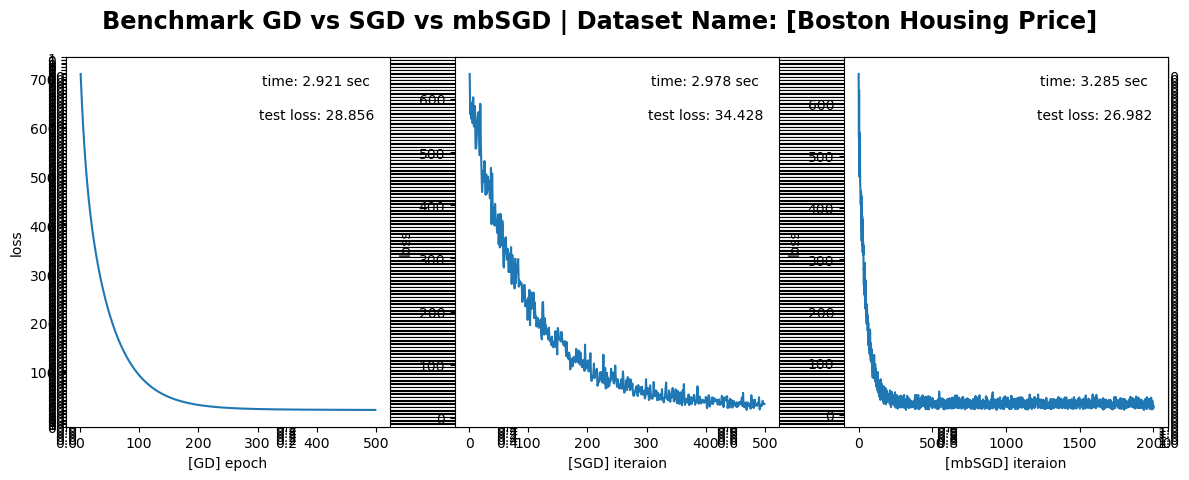

In [12]:
fit_and_plot(X_train, y_train, X_test, y_test, EPOCH)

# Benchmark: by using sklearn　SGDRegressor

In [13]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

@timing
def skl_SGD(verbose):
    model=SGDRegressor(alpha=0,learning_rate="constant",eta0=0.001)
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    mse   = mean_squared_error(y_test, ypred)
    rmse  = mse**(1/2.0)
    if verbose:
        print(f"sklearn Weight vector: {model.coef_}\n interception: {model.intercept_}")
        print("R-squared:", model.score(X_test, y_test))
    
    print(f"MSE:  {mse:.3f}", )
    print(f"RMSE: {rmse:.3f}") 

In [14]:
skl_SGD(False)

MSE:  27.252
RMSE: 5.220
skl_SGD takes time: 0.006 sec seconds



(None, 'time: 0.006 sec')